In [1]:
import json
import os
import time
from glob import glob
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from joblib import Parallel, delayed
from skimage.transform import resize
from tqdm import tqdm

## Introduction

In [2]:
data = pd.read_csv("../data/processed/data_asv_spoof.csv")
data

,speaker_id,filename,attack_id,class_name,filepath,target,subset
0,LA_0085,LA_T_3891170,-,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0,training
1,LA_0097,LA_T_2948101,-,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0,training
2,LA_0084,LA_T_8919107,-,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0,training
3,LA_0081,LA_T_6650735,-,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0,training
4,LA_0086,LA_T_5362691,-,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0,training
...,...,...,...,...,...,...,...
37448,LA_0013,LA_E_7178035,A19,spoof,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,1,testing
37449,LA_0013,LA_E_5285610,A19,spoof,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,1,testing
37450,LA_0007,LA_E_5912220,A19,spoof,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,1,testing
37451,LA_0015,LA_E_5036389,A19,spoof,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,1,testing


In [3]:
ex_fake = data.iloc[0,4]
y_fake,sr = librosa.load(ex_fake, sr = None)
print(sr)
Audio(y_fake, rate = sr)

16000


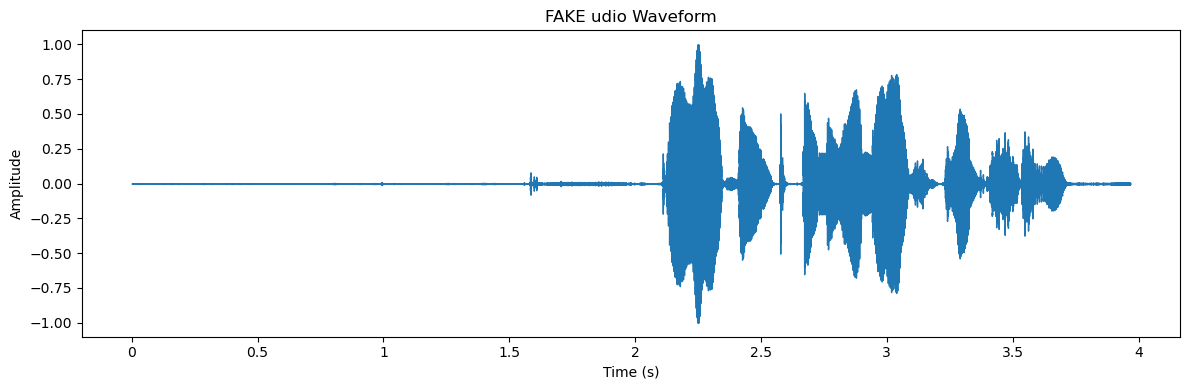

In [4]:
# Plot the waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y_fake, sr=sr)
plt.title('FAKE udio Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

In [6]:
ex_real = data.iloc[1,4]
y_real,sr = librosa.load(ex_real, sr = None)
print(sr)
Audio(y_real, rate = sr)

16000


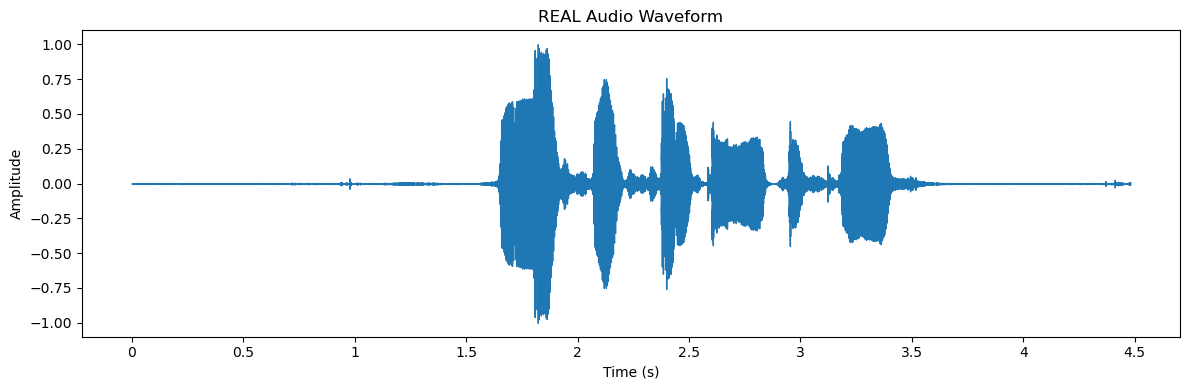

In [7]:
# Plot the waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y_real, sr=sr)
plt.title('REAL Audio Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

## Feature Extraction

In [ ]:
df = pd.read_csv("../data/processed/data_asv_spoof.csv")
df

,speaker_id,filename,attack_id,class_name,filepath,target,subset
0,LA_0085,LA_T_3891170,-,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0,training
1,LA_0097,LA_T_2948101,-,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0,training
2,LA_0084,LA_T_8919107,-,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0,training
3,LA_0081,LA_T_6650735,-,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0,training
4,LA_0086,LA_T_5362691,-,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0,training
...,...,...,...,...,...,...,...
37448,LA_0013,LA_E_7178035,A19,spoof,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,1,testing
37449,LA_0013,LA_E_5285610,A19,spoof,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,1,testing
37450,LA_0007,LA_E_5912220,A19,spoof,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,1,testing
37451,LA_0015,LA_E_5036389,A19,spoof,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,1,testing


In [5]:
df_train = df[df["subset"]=="training"]
df_train.head(5)

,speaker_id,filename,attack_id,class_name,filepath,target,subset
0,LA_0085,LA_T_3891170,-,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0,training
1,LA_0097,LA_T_2948101,-,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0,training
2,LA_0084,LA_T_8919107,-,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0,training
3,LA_0081,LA_T_6650735,-,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0,training
4,LA_0086,LA_T_5362691,-,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0,training


In [6]:
df_val = df[df["subset"]=="validation"]
df_val.head(5)

,speaker_id,filename,attack_id,class_name,filepath,target,subset
7740,LA_0069,LA_D_4511951,-,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0,validation
7741,LA_0070,LA_D_3264952,-,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0,validation
7742,LA_0106,LA_D_2265315,-,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0,validation
7743,LA_0070,LA_D_6150120,-,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0,validation
7744,LA_0078,LA_D_3567303,-,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0,validation


In [7]:
df_test = df[df["subset"]=="testing"]
df_test.head(5)

,speaker_id,filename,attack_id,class_name,filepath,target,subset
15382,LA_0063,LA_E_2714189,-,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0,testing
15383,LA_0034,LA_E_8624167,-,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0,testing
15384,LA_0041,LA_E_6677864,-,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0,testing
15385,LA_0031,LA_E_1357107,-,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0,testing
15386,LA_0032,LA_E_7531986,-,bonafide,D:\sem 7\Bismillah Skripsi\Voice Recog\Data\AS...,0,testing


In [12]:
df_train.groupby(by="class_name").count()

,speaker_id,filename,attack_id,filepath,target,subset
class_name,,,,,,
bonafide,2580,2580,2580,2580,2580,2580
spoof,5160,5160,5160,5160,5160,5160


In [13]:
df_val.groupby(by="class_name").count()

,speaker_id,filename,attack_id,filepath,target,subset
class_name,,,,,,
bonafide,2548,2548,2548,2548,2548,2548
spoof,5094,5094,5094,5094,5094,5094


In [14]:
df_test.groupby(by="class_name").count()

,speaker_id,filename,attack_id,filepath,target,subset
class_name,,,,,,
bonafide,7355,7355,7355,7355,7355,7355
spoof,14716,14716,14716,14716,14716,14716


### Numeric Data

In [15]:

def extract_features_optimized(df, scaler=None, fit_scaler=False, n_jobs=-1):
    start_time = time.perf_counter()
    def _process_file(filepath, target):
        try:
            y, sr = librosa.load(filepath, sr=16000, mono=True)
            S = np.abs(librosa.stft(y))

            chroma = librosa.feature.chroma_stft(S=S, sr=sr).mean(axis=1)
            rms = librosa.feature.rms(S=S).mean()
            spectral_centroid = librosa.feature.spectral_centroid(S=S, sr=sr).mean()
            spectral_bandwidth = librosa.feature.spectral_bandwidth(S=S, sr=sr).mean()
            spectral_rolloff = librosa.feature.spectral_rolloff(S=S, sr=sr).mean()
            zcr = librosa.feature.zero_crossing_rate(y).mean()
            mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), sr=sr, n_mfcc=20).mean(axis=1)

            return [*chroma, rms, spectral_centroid, spectral_bandwidth,
                    spectral_rolloff, zcr, *mfccs, int(target)]
        except Exception as e:
            print(f"Error processing {filepath}: {e}")
            return None

    features = Parallel(n_jobs=n_jobs)(
        delayed(_process_file)(row["filepath"], row["target"])
        for _, row in tqdm(df.iterrows(), total=len(df))
    )

    features = [f for f in features if f is not None]  # filter gagal

    columns = (
        [f'chroma_{i+1}' for i in range(12)] +
        ['rms_mean', 'spectral_centroid_mean', 'spectral_bandwidth_mean',
         'spectral_rolloff_mean', 'zcr_mean'] +
        [f'mfcc_{i+1}' for i in range(20)] + ['label']
    )

    features_df = pd.DataFrame(features, columns=columns)

    feature_columns = columns[:-1]
    if fit_scaler:
        scaler = MinMaxScaler()
        features_df[feature_columns] = scaler.fit_transform(features_df[feature_columns])
    elif scaler is not None:
        features_df[feature_columns] = scaler.transform(features_df[feature_columns])
    else:
        pass  # no scaling applied

    elapsed_time = time.perf_counter() - start_time

    return features_df, scaler, elapsed_time


In [16]:
train_features, scaler, train_time = extract_features_optimized(df_train, fit_scaler=True)
val_features, _, val_time = extract_features_optimized(df_val, scaler=scaler, fit_scaler=False)
test_features, _, test_time = extract_features_optimized(df_test, scaler=scaler, fit_scaler=False)

  0%|          | 0/7740 [00:00<?, ?it/s]

100%|██████████| 22071/22071 [04:51<00:00, 75.77it/s] 


In [ ]:
train_features.to_csv("../data/processed/numeric_train_data.csv", index=False)
val_features.to_csv("../data/processed/numeric_val_data.csv", index=False)
test_features.to_csv("../data/processed/numeric_test_data.csv", index=False)

### Image Data - CNN

In [ ]:
def process_full_audio_data_parallel(train_df, sr=16000, n_mels=128, fixed_frames=128, n_jobs=-1):
    start_time = time.perf_counter()

    def create_mel_spectrogram_full(y, label):
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        mel_resized = resize(mel_spectrogram_db, (n_mels, fixed_frames), mode='reflect', anti_aliasing=True)
        mel_standard = (mel_resized + 80) / 80
        mel_segments = np.expand_dims(mel_standard, axis=-1)
        return mel_segments

    def process_row(row):
        try:
            y, _ = librosa.load(row["filepath"], sr=sr, mono=True)
            label = 0 if row["target"] == 0 else 1
            mel_spectrogram = create_mel_spectrogram_full(y, label)
            return mel_spectrogram, label
        except Exception as e:
            print(f"Error processing file {row['filepath']}: {e}")
            return None

    results = Parallel(n_jobs=n_jobs)(
        delayed(process_row)(row) for _, row in tqdm(train_df.iterrows(), total=len(train_df))
    )

    results = [res for res in results if res is not None]

    if not results:
        return np.array([]), np.array([]), np.array([]), np.array([]), 0

    mel_data, labels, attack_ids, speaker_ids = zip(*results)
    elapsed_time = time.perf_counter() - start_time

    return np.array(mel_data), np.array(labels), np.array(attack_ids), np.array(speaker_ids), elapsed_time



In [ ]:
X_train_full, y_train_full, time_train_full = process_full_audio_data_parallel(df_train)

100%|██████████| 7740/7740 [00:59<00:00, 130.46it/s]


In [ ]:
X_val_full, y_val_full, time_val_full = process_full_audio_data_parallel(df_val)

100%|██████████| 7642/7642 [00:58<00:00, 130.87it/s]


In [31]:
X_test_full, y_test_full, time_test_full = process_full_audio_data_parallel(df_test)































































































































































































































































































































































































100%|██████████| 22071/22071 [02:00<00:00, 182.67it/s]


In [ ]:
np.savez("../data/processed/cnn_train_data.npz", data=X_train_full, label = y_train_full)
np.savez("../data/processed/cnn_val_data.npz", data=X_val_full, label = y_val_full)
np.savez("../data/processed/cnn_test_data.npz", data=X_test_full, label = y_test_full)

### Image Data-CNN_LSTM

In [ ]:


def process_step_audio_data_parallel(train_df, sr=16000, n_mels=128, fixed_frames=128, timesteps=32, n_jobs=-1):
    start_time = time.perf_counter()

    def create_mel_spectrogram_timestep(y):
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        mel_spectrogram_db = (mel_spectrogram_db + 80) / 80
        resized_mel_spectrogram = resize(mel_spectrogram_db, (n_mels, fixed_frames), mode='reflect', anti_aliasing=True)
        
        segment_length = fixed_frames // timesteps
        mel_segments = [resized_mel_spectrogram[:, i * segment_length:(i + 1) * segment_length] for i in range(timesteps)]
        mel_segments = np.array(mel_segments)
        mel_segments = np.expand_dims(mel_segments, axis=-1)  # Add channel dimension

        return mel_segments

    def process_row(row):
        try:
            y, _ = librosa.load(row["filepath"], sr=sr, mono=True)
            label = 0 if row["target"] == 0 else 1
            mel = create_mel_spectrogram_timestep(y)
            return mel, label
        except Exception as e:
            print(f"Error processing file {row['filepath']}: {e}")
            return None

    results = Parallel(n_jobs=n_jobs)(
        delayed(process_row)(row) for _, row in tqdm(train_df.iterrows(), total=len(train_df))
    )

    results = [r for r in results if r is not None]

    if not results:
        return np.array([]), np.array([]), 0

    train_samples_step, train_labels = zip(*results)

    elapsed_time = time.perf_counter() - start_time
    return np.array(train_samples_step), np.array(train_labels), elapsed_time


In [9]:
X_train_step, y_train_step, time_train_step = process_step_audio_data_parallel(df_train)
X_val_step, y_val_step, time_val_step = process_step_audio_data_parallel(df_val)
X_test_step, y_test_step, time_test_step = process_step_audio_data_parallel(df_test)

100%|██████████| 22071/22071 [02:08<00:00, 171.93it/s]


In [ ]:
np.savez("../data/processed/cnn_lstm_train_data.npz", data=X_train_step, label = y_train_step)
np.savez("../data/processed/cnn_lstm_val_data.npz", data=X_val_step, label = y_val_step)
np.savez("../data/processed/cnn_lstm_test_data.npz", data=X_test_step, label = y_test_step)

In [ ]:
train_label = df_train[["class_name", "speaker_id", "attack_id"]]
val_label = df_val[["class_name", "speaker_id", "attack_id"]]
test_label = df_test[["class_name", "speaker_id", "attack_id"]]

In [ ]:
train_label.to_csv("../data/processed/train_label.csv")
val_label.to_csv("../data/processed/val_label.csv")
test_label.to_csv("../data/processed/test_label.csv")